## Model Prediction of BTC-USD Price Using SBi-LSTM and SBi-GRU

### 1. Deklarasi Pustaka

In [1]:
# pustaka untuk manipulasi data-frame
import pandas as pd
from pandas import concat
from pandas import read_csv
from pandas import read_excel

# pustaka untuk madnipulasi data-array
import numpy as np
from numpy import concatenate
from numpy import array

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# pustaka untuk visualisasi data
import seaborn as sns
from matplotlib import pyplot as plt

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
        
# pustaka untuk membuat data latih dan data uji.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# pustaka untuk membuat model prediksi LSTM-RNN
import tensorflow as tf
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# pustaka untuk  evaluasi model prediksi
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

- config models

In [2]:
algorithms = "SBi-LSTM"   # fill the value with SBi-LSTM or SBi-GRU
models = "univariate"     # fill the value with univariate or multivariate

### 2. Akuisisi Data

In [3]:
# set waktu komputasi
start = time.time()

In [4]:
# set random seed
tf.random.set_seed(1234)

In [5]:
# membaca dataset via csv file
dataset = read_csv("dataset/BTC-USD.csv", parse_dates=['Date']);

In [6]:
# set index tanggal
dataset = dataset.set_index("Date");

In [7]:
# menampilkan metadata dataset
dataset.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3408 entries, 2015-01-01 to 2024-04-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3408 non-null   float64
 1   High       3408 non-null   float64
 2   Low        3408 non-null   float64
 3   Close      3408 non-null   float64
 4   Adj Close  3408 non-null   float64
 5   Volume     3408 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 186.4 KB


In [8]:
# menampilkan dataset BTC-USD
print(np.round(dataset[["Open", "High", "Low", "Close", "Adj Close"]], 2))

                Open      High       Low     Close  Adj Close
Date                                                         
2015-01-01    320.43    320.43    314.00    314.25     314.25
2015-01-02    314.08    315.84    313.57    315.03     315.03
2015-01-03    314.85    315.15    281.08    281.08     281.08
2015-01-04    281.15    287.23    257.61    264.20     264.20
2015-01-05    265.08    278.34    265.08    274.47     274.47
...              ...       ...       ...       ...        ...
2024-04-26  64485.37  64789.66  63322.40  63755.32   63755.32
2024-04-27  63750.99  63898.36  62424.72  63419.14   63419.14
2024-04-28  63423.52  64321.48  62793.60  63113.23   63113.23
2024-04-29  63106.36  64174.88  61795.46  63841.12   63841.12
2024-04-30  63839.42  64703.33  59120.07  60636.86   60636.86

[3408 rows x 5 columns]


### 3. Eksplorasi Datsa Analisis

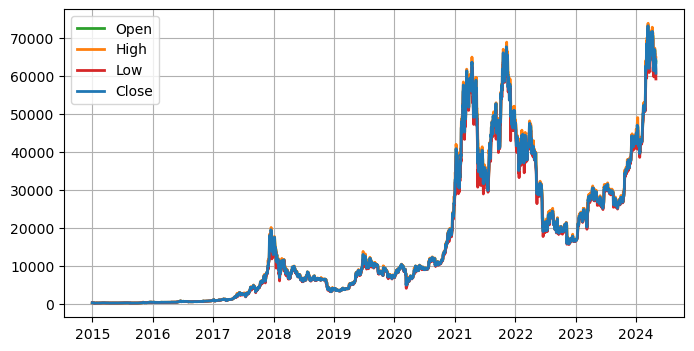

In [9]:
# membuat frame
fig, ax = plt.subplots(figsize = (8,4))

# membuat time series plot
ax.plot(dataset.index.values, dataset["Open"], color="tab:green", label="Open", linewidth=2)
ax.plot(dataset.index.values, dataset["High"], color="tab:orange", label="High", linewidth=2)
ax.plot(dataset.index.values, dataset["Low"], color="tab:red", label="Low", linewidth=2)
ax.plot(dataset.index.values, dataset["Close"], color="tab:blue", label="Close", linewidth=2)

# membuat label-label
ax.legend(loc='upper left')
ax.grid(True)

# menampilkan plot
plt.show()

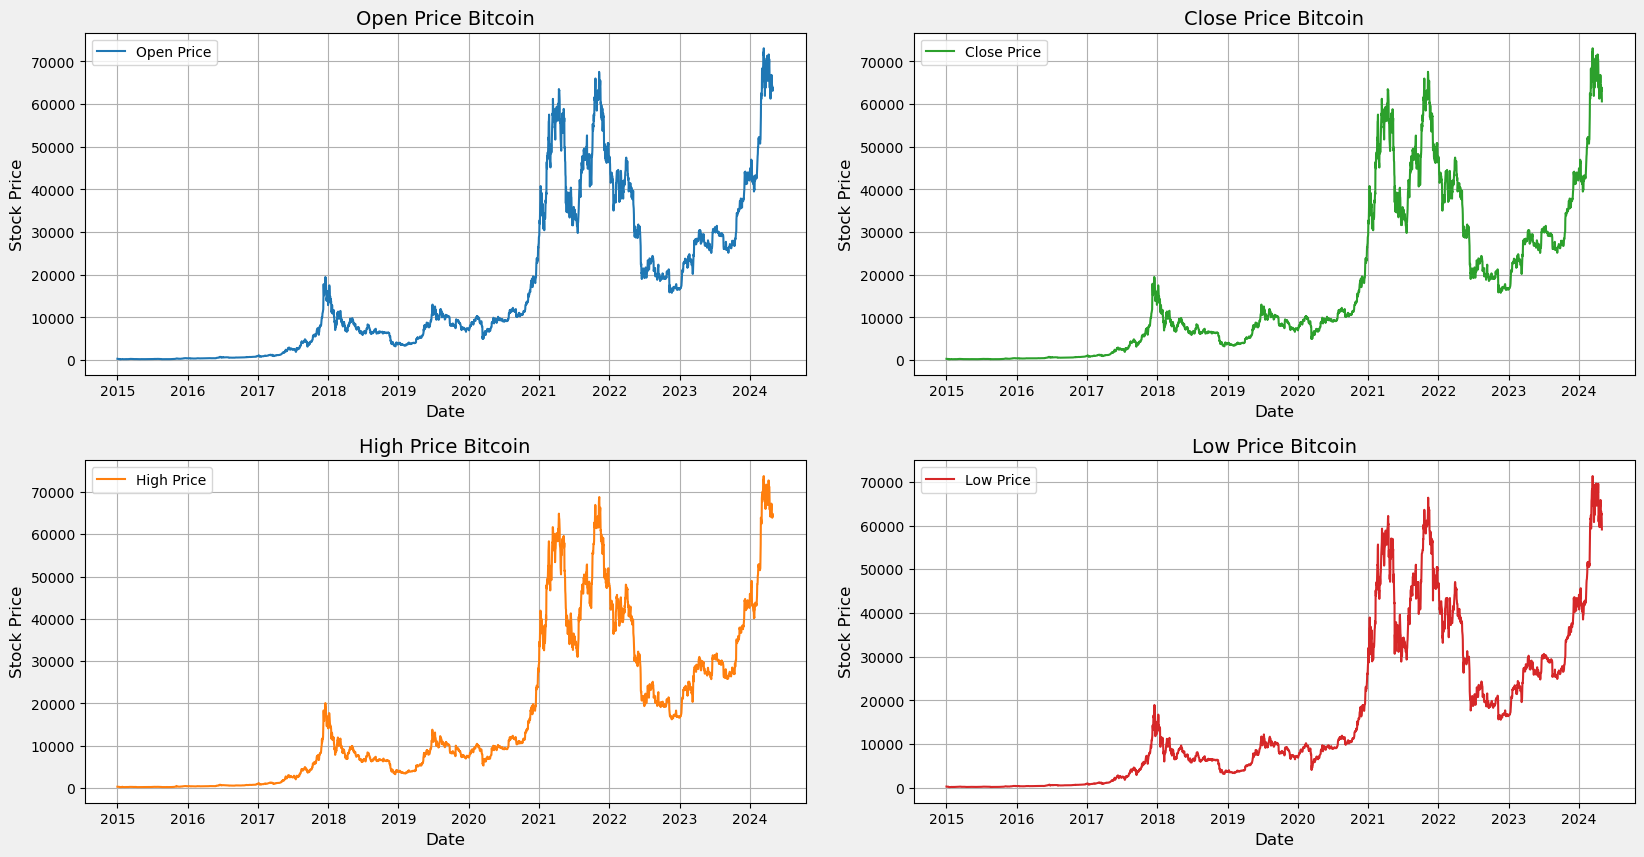

In [10]:
# membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(dataset.index.values, dataset["Open"], color="tab:blue", label="Open Price")

# membuat label-label
ax1.set_title("Open Price Bitcoin", fontsize=14)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price", fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(dataset.index.values, dataset["Close"], color="tab:green", label="Close Price")

# membuat label-label
ax2.set_title("Close Price Bitcoin", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price", fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(dataset.index.values, dataset["High"], color="tab:orange", label="High Price")

# membuat label-label
ax3.set_title("High Price Bitcoin", fontsize=14)
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price", fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(dataset.index.values, dataset["Low"], color="tab:red", label="Low Price")

# membuat label-label
ax4.set_title("Low Price Bitcoin", fontsize=14)
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Stock Price", fontsize=12)
ax4.legend(loc='upper left')
ax4.grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# menampilkan plot
plt.show()

### 4. Praproses Dataset

- Seleksi Fitur

In [11]:
# memilih fitur close price
dataset = dataset.filter(['Close']);

In [12]:
# convert dataframe to series close price
data = dataset.values

In [13]:
np.round(data[:5],5)

array([[314.24899],
       [315.03201],
       [281.082  ],
       [264.19501],
       [274.474  ]])

In [14]:
# melihat dimensi data
data.shape

(3408, 1)

- Normalisasi Data

In [15]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1,1))

In [16]:
np.round(scaled_data[:5],5)

array([[0.00187],
       [0.00188],
       [0.00141],
       [0.00118],
       [0.00132]])

In [17]:
# melihat dimensi data
scaled_data.shape

(3408, 1)

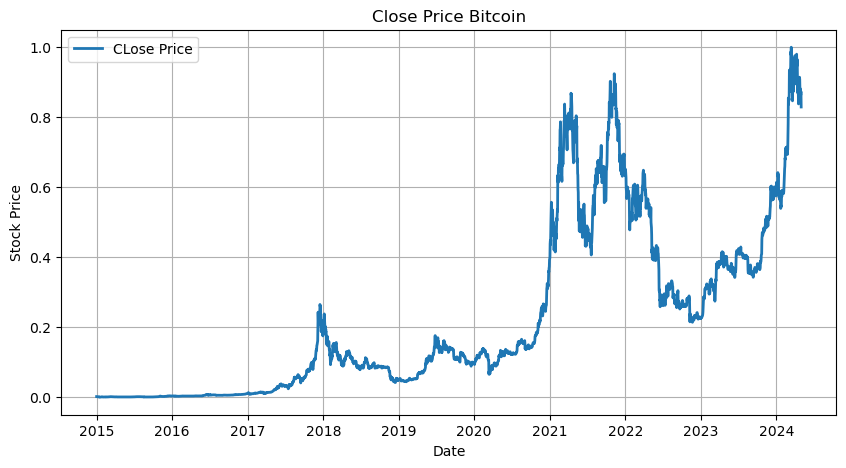

In [18]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset.index.values, scaled_data, color="tab:blue", label="CLose Price", linewidth=2)

# membuat label-label
ax.set_title("Close Price Bitcoin", fontsize=12)
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel("Stock Price", fontsize=10)
ax.legend(loc='upper left')
ax.grid(True)

# menampilkan plot
plt.show()

- Data latih dan Data uji

In [19]:
# split data train and test
train_data, test_data = train_test_split(scaled_data, train_size=0.80, test_size=0.20, shuffle=False)

In [20]:
# data train
np.round(train_data[:5],5)

array([[0.00187],
       [0.00188],
       [0.00141],
       [0.00118],
       [0.00132]])

In [21]:
# melihat dimensi data
train_data.shape

(2726, 1)

In [22]:
# data test
np.round(test_data[:5],5)

array([[0.27947],
       [0.28011],
       [0.28163],
       [0.27171],
       [0.28678]])

In [23]:
# melihat dimensi data
test_data.shape

(682, 1)

- Supervised Learning

In [24]:
# convert an array of values into a dataset matrix

# function for supervised learning
def create_dataset(look_back, dataset):
    
    # declare variable X and Y
    dataX = []
    dataY = []
    
    # for loop for create supervised learning
    for i in range(look_back, len(dataset)):
        
        # insert value X and Y 
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])
        
    # return value X and Y
    return np.array(dataX), np.array(dataY)

In [25]:
# process supervised learning
look_back = 60
x_train, y_train = create_dataset(look_back, train_data)
x_test, y_test = create_dataset(look_back, test_data)

In [26]:
print(x_train.shape, y_train.shape)

(2666, 60) (2666,)


In [27]:
print(x_test.shape, y_test.shape)

(622, 60) (622,)


In [28]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [29]:
print(x_train.shape, x_test.shape)

(2666, 60, 1) (622, 60, 1)


### 5. The prediction model

In [30]:
# The LSTM-RNN architecture
model = tf.keras.Sequential([
    
    # First LSTM layer with Dropout regularisation
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))
    ),
    
    # Secound LSTM layer with Dropout regularisation
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=50, return_sequences=False)
    ),

    # the dropout layers
    tf.keras.layers.Dropout(0.15),
    
    # The output layer
    tf.keras.layers.Dense(1)
])

In [31]:
# Compile the model LSTM
model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
# fit network
history = model.fit(
  x_train, y_train,
  batch_size=8, epochs=50, verbose="auto", 
  validation_data=(x_test, y_test),
  use_multiprocessing=True, shuffle=False
)

Epoch 1/50
334/334 [==============================] - 21s 34ms/step - loss: 0.0021 - val_loss: 0.0316
Epoch 2/50
334/334 [==============================] - 9s 28ms/step - loss: 0.0048 - val_loss: 0.0277
Epoch 3/50
334/334 [==============================] - 9s 28ms/step - loss: 0.0101 - val_loss: 0.0251
Epoch 4/50
334/334 [==============================] - 9s 28ms/step - loss: 0.0100 - val_loss: 0.0180
Epoch 5/50
334/334 [==============================] - 9s 28ms/step - loss: 0.0058 - val_loss: 0.0115
Epoch 6/50
334/334 [==============================] - 10s 29ms/step - loss: 0.0031 - val_loss: 0.0063
Epoch 7/50
334/334 [==============================] - 10s 28ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 8/50
334/334 [==============================] - 10s 29ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 9/50
334/334 [==============================] - 10s 29ms/step - loss: 8.0112e-04 - val_loss: 0.0012
Epoch 10/50
334/334 [==============================] - 10s 30ms/step - loss: 6.364

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 60, 100)           20800     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 81301 (317.58 KB)
Trainable params: 81301 (317.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
predictions = model.predict(x_test)

20/20 [==============================] - 2s 12ms/step


In [35]:
print(predictions[:7])

[[0.41168967]
 [0.4102751 ]
 [0.3862425 ]
 [0.38918173]
 [0.39281464]
 [0.39241815]
 [0.39389262]]


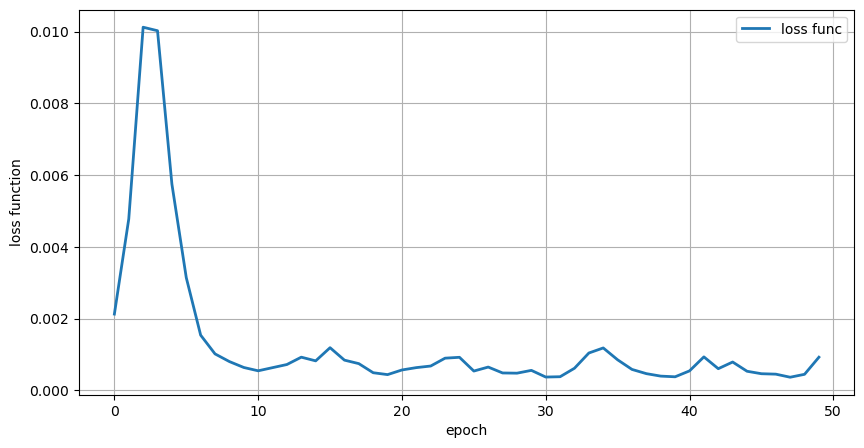

In [36]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="loss func", linewidth=2)

# membuat label-label
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

### 6. Evaluasi Model LSTM-RNN

In [37]:
scores = model.evaluate(x_train, y_train)
scores

84/84 [==============================] - 1s 14ms/step - loss: 0.0277


0.02770436927676201

In [38]:
scores = model.evaluate(x_test, y_test)
scores

20/20 [==============================] - 0s 13ms/step - loss: 0.0131


0.013142597861588001

- MAE (Mean Absolute Error)

In [39]:
mae = mean_absolute_error(y_test, predictions) * 100
print('Test MAE : %.2f' % mae)

Test MAE : 9.51


- MSE (Mean Squared Error)

In [40]:
mse = mean_squared_error(y_test, predictions) * 100
print('Test MSE: %.2f' % mse)

Test MSE: 1.31


- RMSE (Root Mean Squared Error)

In [41]:
rmse = sqrt(mse) * 100
print('Test RMSE: %.2f' % rmse)

Test RMSE: 114.64


- MAPE (Absolute Percentage Error)

In [42]:
mape = mean_absolute_percentage_error(y_test, predictions) * 100
print('Test MAPE: %.2f' % mape)

Test MAPE: 24.63


- Corelation pearson

In [43]:
hasil = np.stack((y_test.reshape(-1), predictions.reshape(-1)), axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])
print(hasil.head())

   data_aktual  prediksi
0     0.315952  0.411690
1     0.283922  0.410275
2     0.287879  0.386243
3     0.292928  0.389182
4     0.291073  0.392815


In [44]:
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.9563 dengan signifikansi 0.0000 


- Complexity time

In [45]:
# Set akhir waktu komputasi 
end = time.time()

In [46]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [47]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:08:32.21


### 7. Visualisasi Data

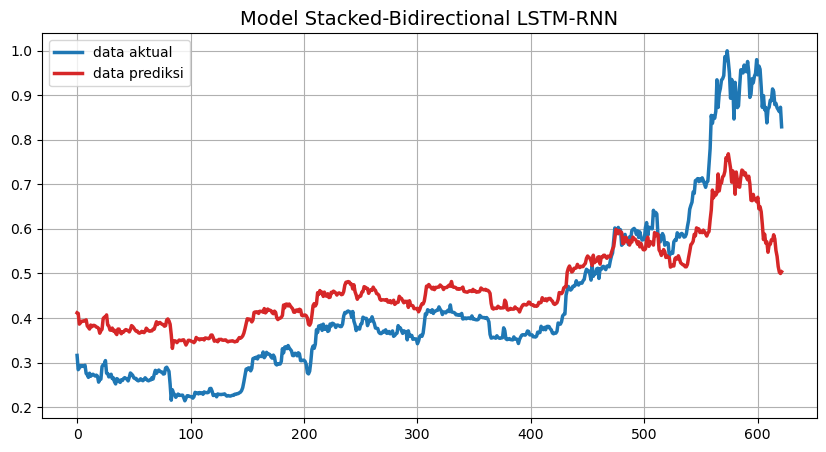

In [48]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(predictions, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Model Stacked-Bidirectional LSTM-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

In [49]:
# inverse value test predictions
testPredictions = scaler.inverse_transform(predictions)

In [50]:
# shift test predictions for plotting
testPredictionsPlot = np.empty_like(scaled_data)
testPredictionsPlot[:, :] = np.nan
testPredictionsPlot[(len(dataset) - testPredictions.shape[0]):len(dataset), :] = testPredictions

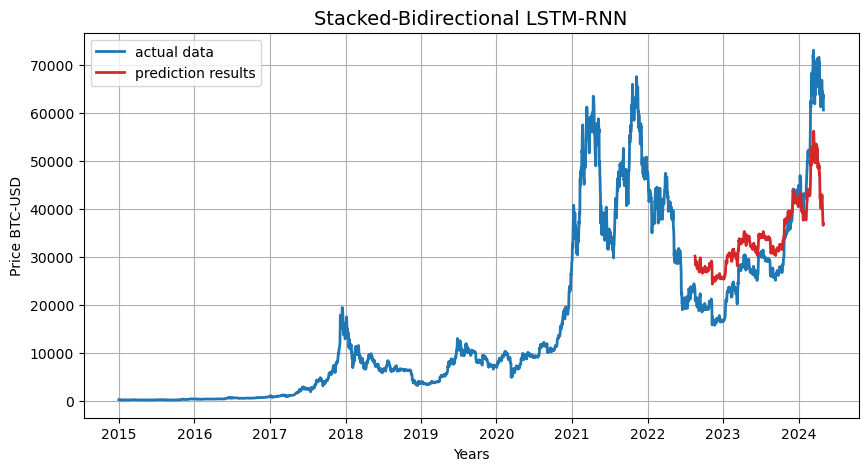

In [51]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="actual data", linewidth=2)
ax.plot(dataset.index.values, testPredictionsPlot, color="tab:red", label="prediction results", linewidth=2)

# membuat label-label
ax.set_title("Stacked-Bidirectional LSTM-RNN", fontsize=14)
ax.set_xlabel("Years", fontsize=10)
ax.set_ylabel("Price BTC-USD", fontsize=10)
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()